LER ARTIGO DO UNIVERSAL E CST GAN E VER QUAIS MÉTRICAS ELES USAM E APLICAR AQUI!!!!!!!!

In [74]:
%load_ext autoreload
%autoreload 2

import os
import sys
import random
import joblib
from pathlib import Path
from aerosandbox import Airfoil, KulfanAirfoil

# Find the project root (the nearest ancestor that contains `src`) and add it to sys.path
cwd = Path.cwd()
project_root = cwd
for _ in range(6):
    if (project_root / "src").exists():
        break
    if project_root.parent == project_root:
        break
    project_root = project_root.parent
else:
    project_root = cwd

proj_path = str(project_root.resolve())
if proj_path not in sys.path:
    # Insert at front so local packages take precedence
    sys.path.insert(0, proj_path)

import tensorflow as tf
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import wandb
from tqdm import tqdm

from src.vae import CSTVariationalAutoencoder
from src.utils import plot_original_and_reconstruction
from src.layers.airfoil_scaler import AirfoilScaler
from src.utils import plot_airfoil_list

from src.airfoil import airfoil_modifications

SEED = 42

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
# ============================================================================
# USER INPUTS
# ============================================================================

# 1. The timestamp folder name in models/cstvae/
RUN_ID = "20260201-172653"  

# 2. The specific epoch number to load
EPOCH = 500                 

# 3. Model Hyperparameters (Must match what was used in training)
NPV = 12
LATENT_DIM = 16

# 4. Number of airfoils to plot during validation
AIRFOILS_TO_PLOT = 16

# Paths
BASE_DIR = Path(proj_path) # Project Root
MODELS_DIR = BASE_DIR / "models" / "cstvae" / RUN_ID
WEIGHTS_PATH = MODELS_DIR / "weights" / f"vae_weights_epoch_{EPOCH}.weights.h5"
SCALER_PATH = MODELS_DIR / "scaler" / "scaler.pkl"
DATA_PATH = BASE_DIR / "data" / "processed" / "val_kulfan_dataset_75.json"

print(f"Loading model from: {RUN_ID}")
print(f"Weights file: {WEIGHTS_PATH}")

Loading model from: 20260201-172653
Weights file: /home/matsouto/py/Generative_airfoil_models/models/cstvae/20260201-172653/weights/vae_weights_epoch_500.weights.h5


In [26]:
# 1. Load the Scaler
if not SCALER_PATH.exists():
    raise FileNotFoundError(f"Scaler not found at {SCALER_PATH}")

print("Loading Scaler...")
scaler = joblib.load(SCALER_PATH)

# 2. Instantiate the VAE Model
print("Building VAE Architecture...")
vae = CSTVariationalAutoencoder(scaler=scaler, npv=NPV, latent_dim=LATENT_DIM)

# 3. Run a dummy forward pass to initialize the graph
# (TensorFlow needs to know input shape to build layers before loading weights)
dummy_input = tf.zeros((1, 26)) 
vae(dummy_input)

# 4. Load Weights
print(f"Loading Weights from Epoch {EPOCH}...")
try:
    vae.load_weights(WEIGHTS_PATH)
    print("✓ Weights loaded successfully.")
except OSError as e:
    print(f"❌ Error loading weights: {e}")
    print("Check if the file path is correct.")

Loading Scaler...
Building VAE Architecture...


/home/matsouto/py/Generative_airfoil_models/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:424: UserWarning: `build()` was called on layer 'encoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/matsouto/py/Generative_airfoil_models/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:424: UserWarning: `build()` was called on layer 'decoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Loading Weights from Epoch 500...
✓ Weights loaded successfully.


In [27]:
# 1. Load Dataframe
print("Loading Validation Dataset...")
val_df = pd.read_json(DATA_PATH)

# 2. Select First 9 Airfoils
val_sample = val_df.iloc[:AIRFOILS_TO_PLOT].copy().reset_index(drop=True)

# 3. Helper to format coordinates
val_sample["coordinates"] = val_sample["coordinates"].apply(np.array)

# 4. Extract Kulfan Parameters (Exact logic from train.py)
# Note: Ensure order (lower vs upper) matches your training script exactly
raw_vectors = val_sample["kulfan_parameters"].apply(
  lambda p: np.concatenate([
    p["lower_weights"],     # Lower
    p["upper_weights"],     # Upper
    [p["TE_thickness"]],    # TE
    [p["leading_edge_weight"]] # LE
    ], axis=0)).to_list()

# 5. Normalize
raw_tensor = tf.convert_to_tensor(raw_vectors, dtype=tf.float32)
weights_raw = raw_tensor[:, :24]
params_raw = raw_tensor[:, 24:]
input_normalized = scaler.transform(weights_raw, params_raw)

print(f"✓ Data prepared. Input shape: {input_normalized.shape}")

Loading Validation Dataset...
✓ Data prepared. Input shape: (16, 26)


Running Inference...
Preparing Airfoil objects...
Generating Plots...


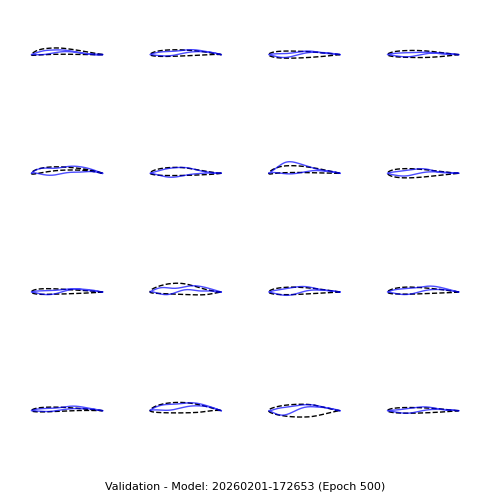

In [28]:
# 1. Run Inference (Reconstruction)
print("Running Inference...")
# training=False removes stochastic noise for validation
_, pred_weights_norm, pred_params_norm = vae(input_normalized, training=False)

# 2. Denormalize Predictions
pred_weights, pred_params = scaler.inverse_transform(
    pred_weights_norm.numpy(), 
    pred_params_norm.numpy()
)

# 3. Generate Coordinates via CST Layer
pred_coords = vae.decoder.cst_transform(
    tf.convert_to_tensor(pred_weights, dtype=tf.float32), 
    tf.convert_to_tensor(pred_params, dtype=tf.float32)
).numpy()

# 4. Prepare Airfoil Objects for the Plotter
print("Preparing Airfoil objects...")

# List A: Original Ground Truth Airfoils (created in Cell 4)
# (Assuming 'validation_airfoils' list was created in Cell 4 logic, 
#  if not, we recreate it here from the dataframe sample)
original_airfoils_objs = [
    Airfoil(coordinates=row["coordinates"], name=row["airfoil_name"]) 
    for _, row in val_sample.iterrows()
]

# List B: Reconstructed Airfoils from VAE
reconstructed_airfoils_objs = []
for coords in pred_coords:
    # We assign a generic name or copy the original name for reference
    reconstructed_airfoils_objs.append(Airfoil(coordinates=coords, name="VAE Reco"))

# 5. Call Your Custom Plot Function
print("Generating Plots...")
plot_original_and_reconstruction(
    original_airfoils_objs,       # Ground Truth
    reconstructed_airfoils_objs,  # VAE Output
    text_label=f"Validation - Model: {RUN_ID} (Epoch {EPOCH})",
    save_path=None,               # Set to None to strictly show in notebook
    filename=None,
    show=True                     # Force show in notebook
)

Calculating metrics for entire validation set (182 samples)...
Generating coordinates for geometric error calculation...

GLOBAL VALIDATION RESULTS (Model: 20260201-172653)
Weights MAE (Normalized):  0.085852
Geometric MAE (Physical):  0.009777


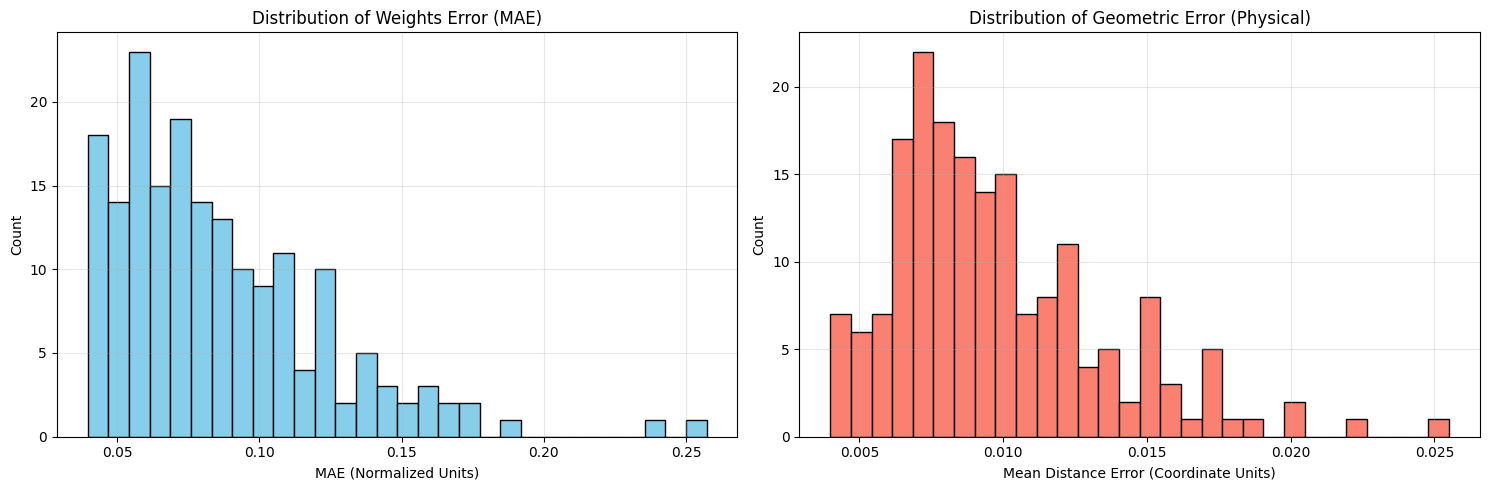

In [29]:
# ============================================================================
# GLOBAL VALIDATION METRICS (WEIGHTS + GEOMETRY)
# ============================================================================

print(f"Calculating metrics for entire validation set ({len(val_df)} samples)...")

# 1. Prepare Full Input Tensor (Raw Physical Values)
# Extract all vectors using the same logic as before
all_vectors = val_df["kulfan_parameters"].apply(
  lambda p: np.concatenate([
    p["lower_weights"],     # Lower
    p["upper_weights"],     # Upper
    [p["TE_thickness"]],    # TE
    [p["leading_edge_weight"]] # LE
    ], axis=0)).to_list()

# Convert to Tensor (Physical Units)
all_tensor_phys = tf.convert_to_tensor(all_vectors, dtype=tf.float32)
all_weights_phys = all_tensor_phys[:, :24]
all_params_phys = all_tensor_phys[:, 24:]

# Normalize for Model Input
all_normalized = scaler.transform(all_weights_phys, all_params_phys)

# 2. Run Inference on the whole batch
# training=False ensures deterministic output
_, pred_w_norm, pred_p_norm = vae(all_normalized, training=False)

# ---------------------------------------------------------
# METRIC A: WEIGHTS MAE (Mathematical Error)
# ---------------------------------------------------------
# Reshape VAE output to match input shape (Batch, 26)
pred_w_flat = tf.reshape(pred_w_norm, [-1, 24]) 
pred_combined_norm = tf.concat([pred_w_flat, pred_p_norm], axis=1)

# Calculate MAE
mae_metric = tf.keras.losses.MeanAbsoluteError()
global_mae = mae_metric(all_normalized, pred_combined_norm).numpy()

# Calculate per-sample error for histogram
errors_weights = tf.reduce_mean(tf.abs(all_normalized - pred_combined_norm), axis=1).numpy()

# ---------------------------------------------------------
# METRIC B: GEOMETRIC MAE (Physical Error)
# ---------------------------------------------------------
print("Generating coordinates for geometric error calculation...")

# A. Generate Ground Truth Coordinates
# Reshape weights to (Batch, 2, 12) for CST Layer
true_weights_reshaped = tf.reshape(all_weights_phys, [-1, 2, 12])
true_coords = vae.decoder.cst_transform(true_weights_reshaped, all_params_phys)

# B. Generate Predicted Coordinates
# Denormalize predictions back to physical units
pred_w_phys, pred_p_phys = vae.scaler.inverse_transform(
    pred_w_norm.numpy(), 
    pred_p_norm.numpy()
)
# Convert to Tensor and Reshape
pred_w_phys_t = tf.convert_to_tensor(pred_w_phys, dtype=tf.float32)
pred_w_phys_reshaped = tf.reshape(pred_w_phys_t, [-1, 2, 12])
pred_p_phys_t = tf.convert_to_tensor(pred_p_phys, dtype=tf.float32)

pred_coords = vae.decoder.cst_transform(pred_w_phys_reshaped, pred_p_phys_t)

# C. Calculate Geometric MAE
# Mean absolute difference between coordinates
val_geo_mae = tf.reduce_mean(tf.abs(true_coords - pred_coords)).numpy()

# Calculate per-sample geometric error for histogram
errors_geo = tf.reduce_mean(tf.reduce_mean(tf.abs(true_coords - pred_coords), axis=1), axis=1).numpy()

# ---------------------------------------------------------
# RESULTS & PLOTTING
# ---------------------------------------------------------
print("\n" + "="*40)
print(f"GLOBAL VALIDATION RESULTS (Model: {RUN_ID})")
print("="*40)
print(f"Weights MAE (Normalized):  {global_mae:.6f}")
print(f"Geometric MAE (Physical):  {val_geo_mae:.6f}")
print("="*40)

# Plot Histograms
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Weights Error
ax[0].hist(errors_weights, bins=30, color='skyblue', edgecolor='black')
ax[0].set_title("Distribution of Weights Error (MAE)")
ax[0].set_xlabel("MAE (Normalized Units)")
ax[0].set_ylabel("Count")
ax[0].grid(True, alpha=0.3)

# Plot 2: Geometric Error
ax[1].hist(errors_geo, bins=30, color='salmon', edgecolor='black')
ax[1].set_title("Distribution of Geometric Error (Physical)")
ax[1].set_xlabel("Mean Distance Error (Coordinate Units)")
ax[1].set_ylabel("Count")
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Valid Airfoil Rate

In [ ]:
BATCH_SIZE = 5000

dummy_latent_vector = tf.random.normal((BATCH_SIZE, LATENT_DIM))

_, w_norm, p_norm = vae.decoder(dummy_latent_vector)

w_norm = tf.reshape(w_norm, [-1, 2 * NPV])

w_phys, p_phys = vae.scaler.inverse_transform(w_norm.numpy(), p_norm.numpy())

w_phys_t = tf.convert_to_tensor(w_phys, dtype=tf.float32)
p_phys_t = tf.convert_to_tensor(p_phys, dtype=tf.float32)

# Reformatamos para (1000, 2, 12) para a camada CST desenhar
w_phys_reshaped = tf.reshape(w_phys_t, [-1, 2, 12])

coords = vae.decoder.cst_transform(w_phys_reshaped, p_phys_t).numpy()

def check_validity(coords):
    x = coords[:, 0]
    y = coords[:, 1]
    le_idx = np.argmin(x)
    
    # Separa superfícies
    upper_y = y[:le_idx+1][::-1]
    lower_y = y[le_idx:]

    # Check: Espessura negativa (tolerância 1e-4)
    thickness = upper_y - lower_y
    if np.any(thickness < -1e-4):
        return False
        
    return True

# Executar Contagem
valid_count = 0
for i in range(BATCH_SIZE):
    if check_validity(coords[i]):
        valid_count += 1

validity_rate = (valid_count / BATCH_SIZE) * 100

print("\n" + "="*40)
print(f"VALID AIRFOIL RATE")
print("="*40)
print(f"Total Generated: {BATCH_SIZE}")
print(f"Valid Airfoils:  {valid_count}")
print(f"Success Rate:    {validity_rate:.2f}%")
print("="*40)


VALID AIRFOIL RATE
Total Generated: 5000
Valid Airfoils:  4585
Success Rate:    91.70%


Identificando perfis inválidos...
Encontrados 36 perfis inválidos.
Muitos erros (36). Plotando os primeiros 16...


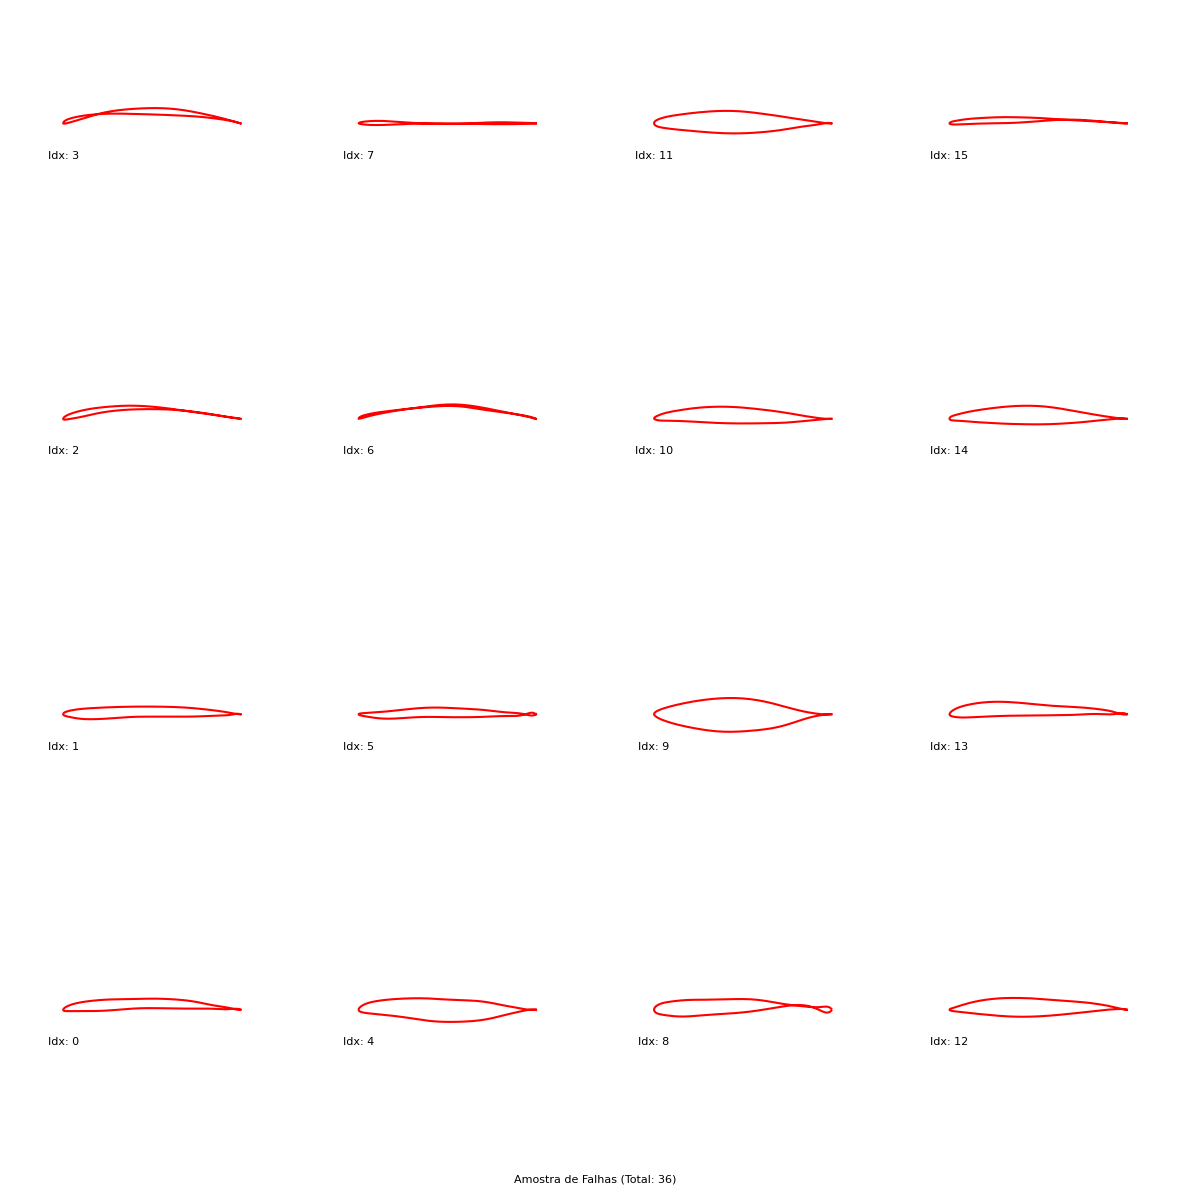

In [77]:
import matplotlib.pyplot as plt
import numpy as np

# Caso precise redefinir a robusta para garantir:
def check_validity_robust(coords):
    x = coords[:, 0]
    y = coords[:, 1]
    le_idx = np.argmin(x)
    
    upper_y = y[:le_idx+1][::-1]
    upper_x = x[:le_idx+1][::-1]
    lower_y = y[le_idx:]
    lower_x = x[le_idx:]

    common_x = np.linspace(0, 1, 100)
    
    try:
        y_up_interp = np.interp(common_x, upper_x, upper_y)
        y_low_interp = np.interp(common_x, lower_x, lower_y)
    except ValueError:
        return False 

    thickness = y_up_interp - y_low_interp
    if np.mean(thickness) < 0: thickness = -thickness # Aceita invertidos
    if np.any(thickness < -1e-3): return False
    return True

# 2. Encontrar os índices dos perfis ruins
print("Identificando perfis inválidos...")
invalid_indices = []
for i in range(len(coords)):
    # Use a mesma função que te deu os 91%
    if not check_validity_robust(coords[i]): 
        invalid_indices.append(i)

print(f"Encontrados {len(invalid_indices)} perfis inválidos.")

# 1. Recuperar as coordenadas dos perfis ruins
bad_airfoils_coords = [coords[i] for i in invalid_indices]

max_plot = 16
if len(bad_airfoils_coords) > max_plot:
    print(f"Muitos erros ({len(bad_airfoils_coords)}). Plotando os primeiros {max_plot}...")
    bad_airfoils_to_plot = bad_airfoils_coords[:max_plot]
else:
    bad_airfoils_to_plot = bad_airfoils_coords

# 2. Plotar usando sua nova função
if bad_airfoils_to_plot:
    plot_airfoil_list(
        bad_airfoils_to_plot,
        text_label=f"Amostra de Falhas (Total: {len(invalid_indices)})",
        color="red",         # Vermelho para destacar erro
        linestyle="-",
        figsize=(12, 12),    # Grande para ver os loops
        filename="invalid_airfoils.png",
        save_path="."        # Salva na pasta atual ou onde preferir
    )